# GeoDev Webinar (ArcGIS API for Python)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-Case" data-toc-modified-id="Use-Case-1">Use Case</a></span></li><li><span><a href="#Import-and-Data-Preparation" data-toc-modified-id="Import-and-Data-Preparation-2">Import and Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Input-Data-(Freeway)" data-toc-modified-id="Input-Data-(Freeway)-2.1">Input Data (Freeway)</a></span></li><li><span><a href="#Input-Data-(Fire)" data-toc-modified-id="Input-Data-(Fire)-2.2">Input Data (Fire)</a></span></li><li><span><a href="#Input-Data-(Wilderness-Preservation-Area)" data-toc-modified-id="Input-Data-(Wilderness-Preservation-Area)-2.3">Input Data (Wilderness Preservation Area)</a></span></li><li><span><a href="#State-and-County-Boundaries-from-Geoenrichment" data-toc-modified-id="State-and-County-Boundaries-from-Geoenrichment-2.4">State and County Boundaries from Geoenrichment</a></span></li></ul></li><li><span><a href="#arcgis.geometry.filters-module" data-toc-modified-id="arcgis.geometry.filters-module-3"><code>arcgis.geometry.filters</code> module</a></span><ul class="toc-item"><li><span><a href="#intersects" data-toc-modified-id="intersects-3.1"><code>intersects</code></a></span></li></ul></li><li><span><a href="#contains-V.S.-within" data-toc-modified-id="contains-V.S.-within-4"><code>contains</code> V.S. <code>within</code></a></span><ul class="toc-item"><li><span><a href="#crosses-V.S.-overlaps" data-toc-modified-id="crosses-V.S.-overlaps-4.1"><code>crosses</code> V.S. <code>overlaps</code></a></span><ul class="toc-item"><li><span><a href="#Visualizing-the-filtered-results" data-toc-modified-id="Visualizing-the-filtered-results-4.1.1">Visualizing the filtered results</a></span></li><li><span><a href="#Consider-the-impacted-roads" data-toc-modified-id="Consider-the-impacted-roads-4.1.2">Consider the impacted roads</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5">Conclusion</a></span></li></ul></div>

## News Story

<b>"The <a href="https://www.fire.ca.gov/incidents/2021/7/14/dixie-fire/">Dixie Fire</a> started on July 13th. The fire is burning on the Plumas National Forest, Lassen National Forest, Lassen Volcanic National Park, and in five counties: Butte, Lassen, Plumas, Shasta and Tehama. The Fly Fire started on July 22nd and was managed under the Dixie Fire East Zone command as the two fires eventually merged into one. The drought, combined with hot weather, strong winds, and exceptionally dry vegetation, has resulted in very active fire behavior."</b>
    - <a href="https://inciweb.nwcg.gov/incident/7690/">Incident Information System</a>
    
It had burned 960,470 acres by September 16, with 86 percent containment.

## Use Case

Let's see how he takes advantage of the `arcgis.geometry.filters` in answering these questions:
  - Are there any highways that intersect with these five counties?
  - Check if any of the Interstate Highways are too close to the wilderness protected areas in these five counties.
  - In case of wildfires, are the wilderness protected areas in a safe distance from the incidents? and which Interstate Highways are too close to the areas impacted by wildfires?
  
`arcgis.geoenrichment`module helps us answer these questions:
 - which counties that are impacted by the Dixie Fire will be of higher risks? 
   - Higher number of populations with disability, low income, no medical insurance, or 65+
  
  
## Import and Data Preparation

First of all, let us import the necessary libraries, and then create a GIS connection object to the ArcGIS online organization.

In [1]:
import pandas as pd

from arcgis.geometry import Geometry, Polyline, Point, Polygon, union, buffer
from arcgis.geometry.filters import intersects, contains, overlaps, crosses, touches, within
from arcgis.geometry.filters import envelope_intersects, index_intersects
from arcgis.geoenrichment import Country, enrich


### The `GIS` Module

In [2]:
from arcgis.gis import GIS
gis = GIS(url="https://www.arcgis.com", username='xxx', password='xxxxx', verify_cert=False)

### The `features` Module

#### Input Data (Freeway)

In [ ]:
from arcgis.features import FeatureLayer

<Item title:"USA Freeway System" type:Feature Layer Collection owner:esri_dm>
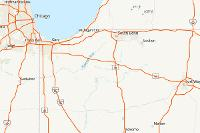

In [3]:
freeway_item = gis.content.search("USA Freeway System AND type:Feature Layer", outside_org=True)[0]
freeway_item

In [4]:
freeway_lyr = freeway_item.layers[0]
freeway_lyr

<FeatureLayer url:"https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Freeway_System/FeatureServer/1">

#### Input Data (Fire)

<Item title:"USA Current Wildfires" type:Feature Layer Collection owner:esri_livefeeds2>
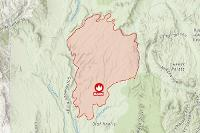

In [5]:
wildfire_item = gis.content.search("USA Current Wildfires AND type:Feature Layer", outside_org=True)[0]
wildfire_item

In [6]:
wildfire_lyr = wildfire_item.layers[0]
wildfire_lyr

<FeatureLayer url:"https://services9.arcgis.com/RHVPKKiFTONKtxq3/arcgis/rest/services/USA_Wildfires_v1/FeatureServer/0">

In [136]:
dixie_wildfires = wildfire_lyr.query(where="IncidentName='DIXIE' AND POOState='US-CA'")
for feature in dixie_wildfires.features:
    print(feature.attributes)   

{'OBJECTID': 74, 'IncidentName': 'DIXIE', 'IncidentTypeCategory': 'WF', 'UniqueFireIdentifier': '2021-CABTU-009205', 'DailyAcres': 960470, 'CalculatedAcres': 960570.4115, 'PercentContained': 86, 'ICS209ReportDateTime': 1631754000000, 'FireDiscoveryDateTime': 1626221702000, 'DiscoveryAcres': 0.1, 'POOCounty': 'Plumas', 'POOState': 'US-CA', 'FireCause': 'Undetermined', 'FireCauseGeneral': None, 'GACC': 'ONCC', 'TotalIncidentPersonnel': 2270, 'IncidentManagementOrganization': 'Type 1 Team', 'FireMgmtComplexity': 'Type 1 Incident', 'ResidencesDestroyed': 736, 'OtherStructuresDestroyed': 593, 'Injuries': 11, 'Fatalities': 1, 'PredominantFuelGroup': None, 'PredominantFuelModel': None, 'PrimaryFuelModel': 'Timber (Litter and Understory)', 'ContainmentDateTime': None, 'ControlDateTime': None, 'FinalAcres': None, 'IsValid': 1, 'FireOutDateTime': None, 'ModifiedOnDateTime': 1631755856000, 'IncidentTypeKind': 'FI', 'IrwinID': '{E9DB628D-DFB7-4C85-BCD6-1254574D946B}', 'GlobalID': None, 'ModifiedOn

In [7]:
wildfire_perimeters_lyr = wildfire_item.layers[1]
wildfire_perimeters_lyr

<FeatureLayer url:"https://services9.arcgis.com/RHVPKKiFTONKtxq3/arcgis/rest/services/USA_Wildfires_v1/FeatureServer/1">

In [155]:
dixie_wildfires_perimeters = wildfire_perimeters_lyr.query(where="IncidentName='DIXIE' AND GACC='ONCC'")
for feature in dixie_wildfires_perimeters.features:
    print(feature.attributes)   

{'OBJECTID': 44, 'IncidentName': 'Dixie', 'FeatureCategory': 'Wildfire Daily Fire Perimeter', 'MapMethod': 'Mixed Methods', 'Comments': None, 'GISAcres': 960580.600378412, 'Label': None, 'CreateDate': 1631234067000, 'DateCurrent': 1631823746000, 'PolygonDateTime': None, 'ComplexName': None, 'ComplexID': None, 'GACC': 'ONCC', 'IMTName': None, 'UnitID': 'CAPNF', 'LocalIncidentID': '009205', 'IRWINID': '{E9DB628D-DFB7-4C85-BCD6-1254574D946B}', 'GeometryID': '{FA5EEE07-C544-4136-A85B-F3D79018FC44}', 'GlobalID': None, 'CurrentDateAge': 0, 'CreateDateAge': 6, 'IncidentTypeCategory': 'WF', 'Shape__Area': 0.411240810453364, 'Shape__Length': 16.3508540566345}


#### Input Data (Wilderness Preservation Area)

<Item title:"Wilderness Areas in the United States" type:Feature Layer Collection owner:wildernesswebmaster99>
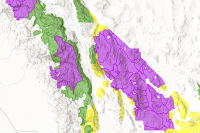

In [8]:
# "Wilderness Areas in the United States"
wild_areas_item = gis.content.search("Wilderness Areas in the United States AND owner:wildernesswebmaster99",
                                     item_type="Feature Layer",
                                     outside_org=True)[0]
wild_areas_item

In [9]:
wild_areas_lyr = wild_areas_item.layers[0]
wild_areas_lyr

<FeatureLayer url:"https://services1.arcgis.com/ERdCHt0sNM6dENSD/arcgis/rest/services/Wilderness_Areas_in_the_United_States/FeatureServer/1">

### The `geometry` Module

#### State and County Boundaries from Geoenrichment

[`GeoEnrichment`](https://developers.arcgis.com/python/guide/performing-geoenrichment/) provides the ability to get facts about a location or area. Using GeoEnrichment, you can get information about the people, places, and businesses in a specific area or within a certain distance or drive time from a location. It enables you to query and use information from a large collection of data sets including population, income, housing, consumer behavior, and the natural environment.

Next, `arcgis.geoenrichment.Country` is used to derive the geometries of the five counties: `Butte, Lassen, Plumas, Shasta and Tehama`.

In [10]:
usa = Country.get('US')
type(usa)

arcgis.geoenrichment.enrichment.Country

To learn more about GeoEnrichment, refer to the guide on this module [here](https://developers.arcgis.com/python/guide/performing-geoenrichment/).

In [11]:
named_area_butte_county = usa.search(query='Butte, CA', layers=['US.Counties'])[0]
named_area_butte_county

<NamedArea name:"Butte County" area_id="06007", level="US.Counties", country="United States">

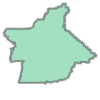

In [12]:
named_area_butte_county.geometry

In [13]:
sr_bt_county = named_area_butte_county.geometry["spatialReference"]
sr_bt_county

{'wkid': 4326, 'latestWkid': 4326}

In [14]:
named_area_4_counties = usa.search(query='Lassen, Plumas, Shasta, Tehama', layers=['US.Counties'])
for county in named_area_4_counties:
    display(county)

<NamedArea name:"Lassen County" area_id="06035", level="US.Counties", country="United States">

<NamedArea name:"Tehama County" area_id="06103", level="US.Counties", country="United States">

<NamedArea name:"Plumas County" area_id="06063", level="US.Counties", country="United States">

<NamedArea name:"Shasta County" area_id="06089", level="US.Counties", country="United States">

#### Create a Unioned geometry of the impacted counties

In [15]:
union_counties = union(spatial_ref=sr_bt_county, geometries=[named_area_butte_county.geometry,
                          named_area_4_counties[0].geometry, named_area_4_counties[1].geometry,
                          named_area_4_counties[2].geometry, named_area_4_counties[3].geometry])

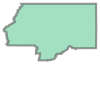

In [16]:
union_counties

### `arcgis.mapping` module and `arcgis.geometry.filters` sub-module

Now all input data are ready, you are all set up to start creating spatial filters! The `arcgis.geometry.filters` module contains functions to filter query results of a feature or imagery layer by a spatial relationship with another geometry. You are going to see how `intersects()`, `contains`, etc. are being used to answer Jim's questions in the following sections. Before we get started, let us visualize how these layers and counties overlay spatially with a help of a map.


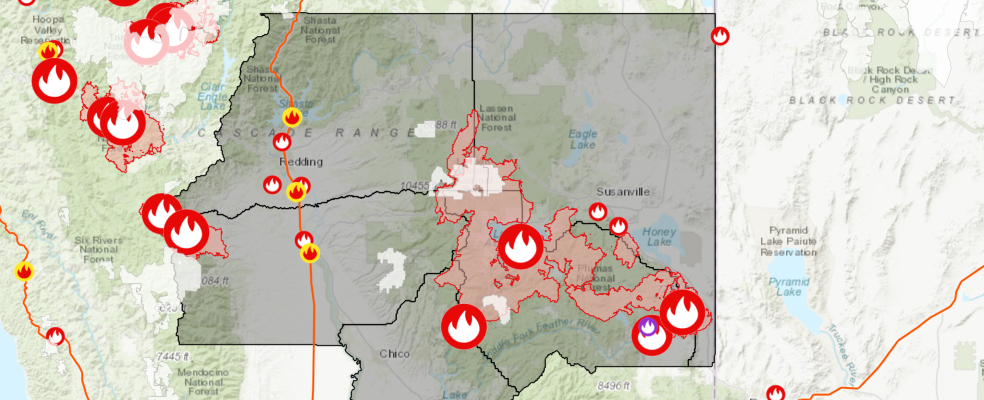

In [60]:
map1 = gis.map('Plumas National Forest, California')
map1.extent = union_counties.geoextent
map1

In [58]:
# draw the counties
map1.draw(named_area_butte_county.geometry) # large gray polygon
for county in named_area_4_counties:
    map1.draw(county.geometry)

In [59]:
map1.add_layer(freeway_item) # red lines
map1.add_layer(wildfire_perimeters_lyr) # pink polygons
map1.add_layer(wildfire_item) # dots
map1.add_layer(wild_areas_item, {"opacity":0.75}) # white polygons

### `intersects`

#### `intersects` with Polygons (Fire Burnt Areas)

To verify if the perimeters of the Dixie Fire intersect with all of the five counties, we will use `arcgis.geometry.filters.intersects(geometry, sr=None)` to create a geometry filter object that filters results whose geometry intersects with the specified geometry.

In [17]:
# construct a geometry filter using the filter geometry
bt_county_filter = intersects(named_area_butte_county.geometry, 
                              sr=sr_bt_county)
type(bt_county_filter)

dict

In [18]:
bt_county_filter.keys()

dict_keys(['geometry', 'geometryType', 'spatialRel', 'inSR'])

In [19]:
bt_county_filter['spatialRel']

'esriSpatialRelIntersects'

In [20]:
df_bt_county_Wildfire = wildfire_perimeters_lyr.query(geometry_filter=bt_county_filter, 
                                                      as_df=True)
df_bt_county_Wildfire

,OBJECTID,IncidentName,FeatureCategory,MapMethod,Comments,GISAcres,Label,CreateDate,DateCurrent,PolygonDateTime,...,LocalIncidentID,IRWINID,GeometryID,GlobalID,CurrentDateAge,CreateDateAge,IncidentTypeCategory,Shape__Area,Shape__Length,SHAPE
0,47,Dixie,Wildfire Daily Fire Perimeter,Mixed Methods,None,960335.225476,None,2021-09-10 00:34:27,2021-09-14 15:36:23.259000063,NaT,...,009205,{E9DB628D-DFB7-4C85-BCD6-1254574D946B},{FA5EEE07-C544-4136-A85B-F3D79018FC44},None,0,5,WF,0.411156,16.232588,"{""rings"": [[[-121.088981774, 40.322164613], [-..."


In [65]:
for county in named_area_4_counties:
    county_filter = intersects(county.geometry, 
                               sr=sr_bt_county)
    county_Wildfire = wildfire_perimeters_lyr.query(geometry_filter=county_filter, 
                                                    as_df=True)
    display(county_Wildfire)

,OBJECTID,IncidentName,FeatureCategory,MapMethod,Comments,GISAcres,Label,CreateDate,DateCurrent,PolygonDateTime,...,LocalIncidentID,IRWINID,GeometryID,GlobalID,CurrentDateAge,CreateDateAge,IncidentTypeCategory,Shape__Area,Shape__Length,SHAPE
0,7,Sugar,Wildfire Daily Fire Perimeter,Mixed Methods,None,105075.726768,None,2021-07-11 00:56:31,2021-07-20 21:42:10.000000000,2021-07-09 15:13:18,...,001046,{33088F36-F802-4500-86A4-82DA6A62425F},{220203D0-514E-481D-BCA4-507FD1885B6A},None,56,65,WF,0.044778,2.314222,"{""rings"": [[[-120.205405115, 39.932618559], [-..."
1,47,Dixie,Wildfire Daily Fire Perimeter,Mixed Methods,None,960335.225476,None,2021-09-10 00:34:27,2021-09-14 15:36:23.259000063,NaT,...,009205,{E9DB628D-DFB7-4C85-BCD6-1254574D946B},{FA5EEE07-C544-4136-A85B-F3D79018FC44},None,0,4,WF,0.411156,16.232588,"{""rings"": [[[-121.088981774, 40.322164613], [-..."


,OBJECTID,IncidentName,FeatureCategory,MapMethod,Comments,GISAcres,Label,CreateDate,DateCurrent,PolygonDateTime,...,LocalIncidentID,IRWINID,GeometryID,GlobalID,CurrentDateAge,CreateDateAge,IncidentTypeCategory,Shape__Area,Shape__Length,SHAPE
0,47,Dixie,Wildfire Daily Fire Perimeter,Mixed Methods,None,960335.225476,None,2021-09-10 00:34:27.000000000,2021-09-14 15:36:23.259000063,NaT,...,009205,{E9DB628D-DFB7-4C85-BCD6-1254574D946B},{FA5EEE07-C544-4136-A85B-F3D79018FC44},None,0,4,WF,0.411156,16.232588,"{""rings"": [[[-121.088981774, 40.322164613], [-..."
1,78,MCFARLAND,Wildfire Daily Fire Perimeter,Infrared Image,None,122350.299317,None,2021-08-27 04:08:11.698999882,2021-08-31 03:29:22.000000000,2021-08-27,...,001175,{938686BB-0F52-47B2-B077-EB307941D939},{D05994CC-EC28-4432-B160-ABC2FE51423A},None,14,18,WF,0.052469,2.212120,"{""rings"": [[[-122.906441454, 40.3406764310001]..."


,OBJECTID,IncidentName,FeatureCategory,MapMethod,Comments,GISAcres,Label,CreateDate,DateCurrent,PolygonDateTime,...,LocalIncidentID,IRWINID,GeometryID,GlobalID,CurrentDateAge,CreateDateAge,IncidentTypeCategory,Shape__Area,Shape__Length,SHAPE
0,7,Sugar,Wildfire Daily Fire Perimeter,Mixed Methods,None,105075.726768,None,2021-07-11 00:56:31,2021-07-20 21:42:10.000000000,2021-07-09 15:13:18,...,001046,{33088F36-F802-4500-86A4-82DA6A62425F},{220203D0-514E-481D-BCA4-507FD1885B6A},None,56,65,WF,0.044778,2.314222,"{""rings"": [[[-120.205405115, 39.932618559], [-..."
1,47,Dixie,Wildfire Daily Fire Perimeter,Mixed Methods,None,960335.225476,None,2021-09-10 00:34:27,2021-09-14 15:36:23.259000063,NaT,...,009205,{E9DB628D-DFB7-4C85-BCD6-1254574D946B},{FA5EEE07-C544-4136-A85B-F3D79018FC44},None,0,4,WF,0.411156,16.232588,"{""rings"": [[[-121.088981774, 40.322164613], [-..."


,OBJECTID,IncidentName,FeatureCategory,MapMethod,Comments,GISAcres,Label,CreateDate,DateCurrent,PolygonDateTime,...,LocalIncidentID,IRWINID,GeometryID,GlobalID,CurrentDateAge,CreateDateAge,IncidentTypeCategory,Shape__Area,Shape__Length,SHAPE
0,47,Dixie,Wildfire Daily Fire Perimeter,Mixed Methods,None,960335.225476,None,2021-09-10 00:34:27.000000000,2021-09-14 15:36:23.259000063,NaT,...,009205,{E9DB628D-DFB7-4C85-BCD6-1254574D946B},{FA5EEE07-C544-4136-A85B-F3D79018FC44},None,0,4,WF,0.411156,16.232588,"{""rings"": [[[-121.088981774, 40.322164613], [-..."
1,78,MCFARLAND,Wildfire Daily Fire Perimeter,Infrared Image,None,122350.299317,None,2021-08-27 04:08:11.698999882,2021-08-31 03:29:22.000000000,2021-08-27,...,001175,{938686BB-0F52-47B2-B077-EB307941D939},{D05994CC-EC28-4432-B160-ABC2FE51423A},None,14,18,WF,0.052469,2.212120,"{""rings"": [[[-122.906441454, 40.3406764310001]..."


#### `intersects` with Polylines (highways)

To find which parts of interstate highways layer intersect with the Butt County alone V.S. with the unioned_5_counties, we will use `arcgis.geometry.filters.intersects(geometry, sr=None)` to create a geometry filter object that filters results whose geometry intersects with the specified geometry.

In [22]:
# query a feature layer for features that meet filter criteria (Tahama & Shasta counties)
union_counties_filter = intersects(union_counties, 
                                   sr=sr_bt_county)
union_counties_Interstate = freeway_lyr.query(geometry_filter=union_counties_filter, 
                                              as_df=True)
union_counties_Interstate[["OBJECTID","ROUTE_NUM","DIST_MILES","DIST_KM"]]

,OBJECTID,ROUTE_NUM,DIST_MILES,DIST_KM
0,674,I5,1367.39521,2200.61367


The results above of an `intersects` filter on the query show only 1 Interstate highway go through (or should we say... intersect) any of these 5 counties - the highway `I5`. If you are interested in finding out more information about any of the resulting highways, such as the specific geometry/shape, you can run the subsequent two cells to create composite filtering criteria (with `where=` and `geometry_filter=`) to get a finer query result. After that, parse the properties to get more details.

In [23]:
# query a feature layer for features that meet filter criteria
union_counties_I5 = freeway_lyr.query(where="ROUTE_NUM = 'I5'",
                                      geometry_filter=union_counties_filter)
union_counties_I5

<FeatureSet> 1 features

{'OBJECTID': 674, 'ROUTE_NUM': 'I5', 'CLASS': 'I', 'NUMBER': '5', 'SUFFIX': ' ', 'DIST_MILES': 1367.39521, 'DIST_KM': 2200.61367}


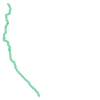

In [24]:
for feature in union_counties_I5.features:
    print(feature.attributes)   
    geom_dict = feature.geometry
    geom_dict["spatialReference"] = sr_bt_county
    freeway_obj = Polyline(geom_dict)
    display(freeway_obj)

## `contains` V.S. `within`

In the previous section, we have sorted out that Interstate Highway `I5`, intersect with 2 of the 5 impacted counties. Now, let us find out which highways are entirely contained in these counties. You will need to use `arcgis.geometry.filters.contains(geometry, sr=None)` to compose the spatial filter that aims to return a feature if its shape is wholly contained within the search geometry (valid for all shape type combinations).

On a side note, `arcgis.geometry.filters.within(geometry, sr=None)` is the opposite to `contains` in that it returns a feature if its shape wholly contains the search geometry (valid for all shape type combinations).

In [25]:
# construct a geometry filter using the filter geometry
bt_county_filter2 = within(named_area_butte_county.geometry, 
                           sr=sr_bt_county)

In [26]:
# query a feature layer for features that meet filter criteria
df_bt_county_Interstate2 = freeway_lyr.query(geometry_filter=bt_county_filter2, 
                                             as_df=True)
display(df_bt_county_Interstate2.shape)
df_bt_county_Interstate2[["OBJECTID","ROUTE_NUM","DIST_MILES","DIST_KM"]].head()

(0, 8)

,OBJECTID,ROUTE_NUM,DIST_MILES,DIST_KM


From the cell output above, none of Interstate Highways is contained within the county boundaries of Butte County. What about the other 4 impacted counties?

In [27]:
union_counties_filter2 = within(union_counties, 
                                sr=sr_bt_county)
df_union_counties_Interstate2 = freeway_lyr.query(geometry_filter=union_counties_filter2, 
                                                  as_df=True)
if not df_union_counties_Interstate2.empty:
    display(df_union_counties_Interstate2)
    print(df_df_union_counties_Interstate2["ROUTE_NUM"].tolist())

The cells above show that there are no freeways being contained inside of, or within the county boundaries.

### `crosses` V.S. `overlaps`

Filters `crosses` and `overlaps` share some common aspects in their definitions:
  - `arcgis.geometry.filters.crosses(geometry, sr=None)` returns a feature if the intersection of the interiors of the two shapes is not empty and has a lower dimension than the maximum dimension of the two shapes. Two lines that share an endpoint in common do not cross. Valid for Line/Line, Line/Area, Multi-point/Area, and Multi-point/Line shape type combinations.
  - `arcgis.geometry.filters.overlaps(geometry, sr=None)` returns a feature if the intersection of the two shapes results in an object of the same dimension, but different from both of the shapes. Applies to Area/Area, Line/Line, and Multi-point/Multi-point shape type combinations.

The major difference is that `overlaps` requires two shapes with the same dimension (e.g. Area/Area, Line/Line, and Multi-point/Multi-point shape type combinations), while `crosses` can operate on two shapes whose intersection has a lower dimension than the maximum dimension of the two.

<div class="alert alert-info">
    <b>Note:</b> The <code>wild_areas_lyr</code> layer pulls live wildfire information. Hence, when you run this notebook, you might see different set of results for the cells below.
</div>

In [20]:
# create a filter
union_counties_filter = intersects(union_counties, sr=sr_bt_county)
# query a feature layer for features that meet filter criteria
county_wildfire = wildfire_perimeters_lyr.query(geometry_filter=union_counties_filter)
county_wildfire

<FeatureSet> 3 features

In [21]:
# alternatively
df_county_wildfire = wildfire_perimeters_lyr.query(geometry_filter=union_counties_filter, as_df=True)
df_county_wildfire

,OBJECTID,IncidentName,FeatureCategory,MapMethod,Comments,GISAcres,Label,CreateDate,DateCurrent,PolygonDateTime,...,LocalIncidentID,IRWINID,GeometryID,GlobalID,CurrentDateAge,CreateDateAge,IncidentTypeCategory,Shape__Area,Shape__Length,SHAPE
0,7,Sugar,Wildfire Daily Fire Perimeter,Mixed Methods,None,105075.726768,None,2021-07-11 00:56:31.000000000,2021-07-20 21:42:10.000000000,2021-07-09 15:13:18,...,001046,{33088F36-F802-4500-86A4-82DA6A62425F},{220203D0-514E-481D-BCA4-507FD1885B6A},None,56,66,WF,0.044778,2.314222,"{""rings"": [[[-120.205405115, 39.932618559], [-..."
1,47,Dixie,Wildfire Daily Fire Perimeter,Mixed Methods,None,960335.225476,None,2021-09-10 00:34:27.000000000,2021-09-14 15:36:23.259000063,NaT,...,009205,{E9DB628D-DFB7-4C85-BCD6-1254574D946B},{FA5EEE07-C544-4136-A85B-F3D79018FC44},None,0,5,WF,0.411156,16.232588,"{""rings"": [[[-121.088981774, 40.322164613], [-..."
2,79,MCFARLAND,Wildfire Daily Fire Perimeter,Infrared Image,None,122350.299317,None,2021-08-27 04:08:11.698999882,2021-08-31 03:29:22.000000000,2021-08-27 00:00:00,...,001175,{938686BB-0F52-47B2-B077-EB307941D939},{D05994CC-EC28-4432-B160-ABC2FE51423A},None,14,18,WF,0.052469,2.212120,"{""rings"": [[[-122.906441454, 40.3406764310001]..."


The above result shows that there are 3 wildfires reported in this unioned polygon (of the 5 counties).

In [22]:
fire_buffer_list = []
wild_areas_list = []

# loop through all point features - wildfire incidents
for feature in county_wildfire.features:
    dict_geom = feature.geometry
    dict_geom["spatialReference"] = sr_bt_county
    
    # create buffered area around the wildfire centers
    #burnt_area = Geometry(feature.geometry)
    f_buffer = buffer(  geometries=[Polygon(dict_geom)],
                        in_sr=4326,
                        out_sr=3857,
                        distances=0.01,
                        unit=9001)
    fire_buffer_list.append(f_buffer[0])

    # creates a spatial filter
    f_buffer_filter = intersects(f_buffer[0], sr=3857)

    # query a feature layer for features that meet filter criteria;
    # result == wilderness prevention areas that overlap with the wildfire buffered zones
    f_buffer_wild_areas = wild_areas_lyr.query(geometry_filter=f_buffer_filter)
    df_f_buffer_wild_areas = f_buffer_wild_areas.sdf

    # print results and save
    if df_f_buffer_wild_areas.shape[0] > 0:
        display(df_f_buffer_wild_areas[["OBJECTID","NAME","Land_Type"]])
        wild_areas_list.append(f_buffer_wild_areas)

,OBJECTID,NAME,Land_Type
0,227,Lassen Volcanic Wilderness,Private Land
1,866,Bucks Lake Wilderness,Private Land


#### Visualizing the filtered results

Next, let us visualize the **wildfires**, the **buffered zone impacted by wildfires**, and the impacted **wilderness preservation areas** on a single MapView.


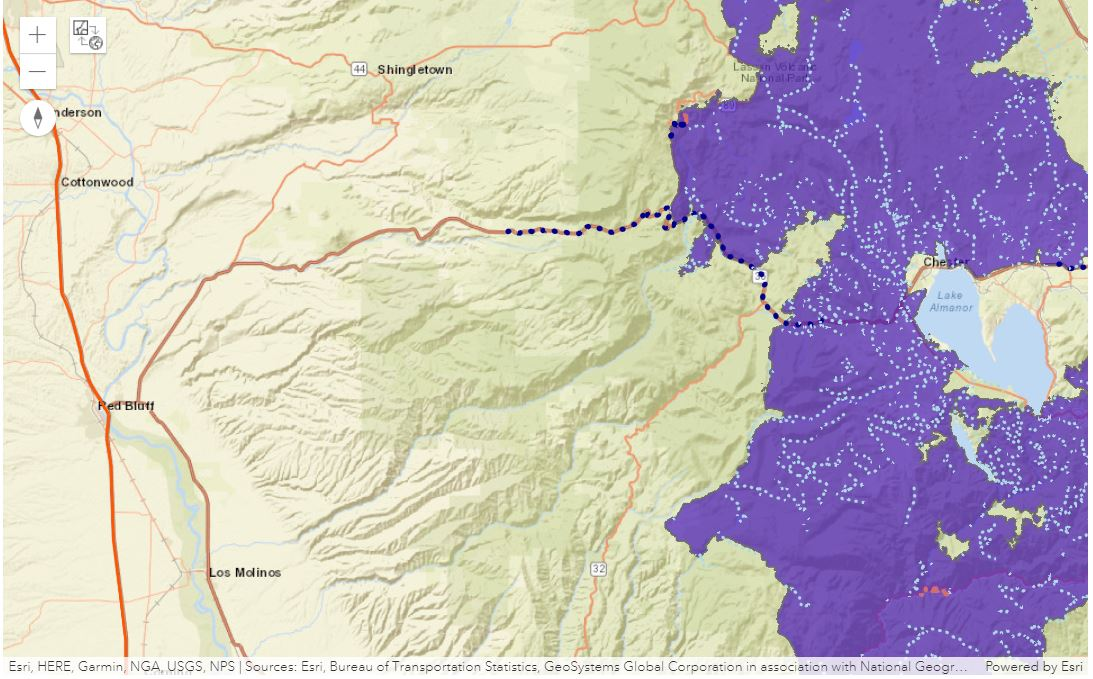

In [1]:
map3 = gis.map('Plumas National Forest, CA')
map3.basemap = 'streets'
map3.geoextent = union_counties.extent
map3.zoom = 10.5
map3.layout.height = '600px'
map3

In [39]:
map3.clear_graphics()

In [40]:
# draw the fires
map3.draw(county_wildfire,
          symbol = {"type" : "esriSFS","style": "esriSFSSolid",
                    "color": [0,0,0,76],
                    "outline": {"type": "esriSLS","style": "esriSLSSolid",
                                "color": [110,110,110,255],"width": 1
                      }
                  })

In [41]:
# draw buffers around fires
for f_b in fire_buffer_list:
    map3.draw(f_b,
              symbol = {"type" : "esriSFS","style": "esriSFSSolid",
                        "color": [76,0,255,115],
                        "opacity": 0.75,
                        "outline": {"type": "esriSLS","style": "esriSLSSolid",
                                    "color": [110,110,110,255],"width": 1
                                   }
                      })

In [42]:
# draw the wild areas affeted
for w_a in wild_areas_list:
    map3.draw(w_a,
              symbol = {"type" : "esriSFS","style": "esriSFSSolid",
                        "color": [215,76,0,255],
                        "opacity": 0.5,
                        "outline": {"type": "esriSLS","style": "esriSLSSolid",
                                    "color": [210,110,110,255],"width": 2
                                   }
                      })

#### Consider the impacted roads

In order to decide what secondary roads and local roads might get affected by the wildfire in SB County, we need to first create a FeatureLayer object from the transportation <a href="https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale/MapServer">resources</a> provided by census bureau.

In [27]:
list_of_MapFeatureLayer = gis.content.search("Transportation_LargeScale", outside_org=True)[1].layers
secondary_roads_layer = list_of_MapFeatureLayer[1]
local_roads_layer = list_of_MapFeatureLayer[2]

In [ ]:
# alternative way
fl_url = "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale/MapServer"
secondary_roads_layer = FeatureLayer(fl_url+"/1")
local_roads_layer = FeatureLayer(fl_url+"/2")

We can use the class `PythonSwitch` defined below to explore all possible spatial relations within `arcgis.geometry.filters`, and discover the differences of each spatial filter:

In [28]:
# Implement Python Switch Case Statement using Class
class PythonSwitch:
    def switch(self, op):
        default = "Unsupported Operation"
        return getattr(self, 'case_' + str(op), lambda: default)()

    def case_1(self):
        return crosses(f_buffer, sr=sr_bt_county)
 
    def case_2(self):
        return contains(f_buffer, sr=sr_bt_county)
 
    def case_3(self):
        return intersects(f_buffer, sr=sr_bt_county)
    
    def case_4(self):
        return overlaps(f_buffer, sr=sr_bt_county)
 
    def case_5(self):
        return touches(f_buffer, sr=sr_bt_county)
 
    def case_6(self):
        return within(f_buffer, sr=sr_bt_county)
    
    def case_7(self):
        return envelope_intersects(f_buffer, sr=sr_bt_county)
 
    def case_8(self):
        return index_intersects(f_buffer, sr=sr_bt_county)

In [ ]:
# For experimental purposes, just target at one of the fire buffered areas
op_list = ['crosses','contains','intersects','overlaps','touches','within','envelope_intersects','index_intersects']

for f_buffer in fire_buffer_list[1:2]:
    # switch case to loop thru all spatial relations
    for i in range(1,3):
        # creates a spatial filter
        s = PythonSwitch()
        f_buffer_filter = s.switch(i)

        # query a feature layer for features that meet filter criteria
        f_buffer_sec_roads = secondary_roads_layer.query(where="0=0", geometry_filter=f_buffer_filter)
        df_f_buffer_sec_roads = f_buffer_sec_roads.sdf

        # print results and save
        if df_f_buffer_sec_roads.shape[0] > 0:
            print(f"Op {i} {op_list[i]}: {df_f_buffer_sec_roads.shape[0]}")
            display(df_f_buffer_sec_roads[["BASENAME","MTFCC","NAME","OBJECTID"]])
        else:
            print(f"Op {i} {op_list[i]}: 0")

Op 1 contains: 10


,BASENAME,MTFCC,NAME,OBJECTID
0,36,S1200,State Rte 36,40737
1,36,S1200,State Rte 36,40738
2,36,S1200,State Rte 36,40739
3,36,S1200,State Rte 36,40740
4,395,S1200,US Hwy 395 E,40750
5,Feather Lake,S1200,Feather Lake Hwy,85570
6,36,S1200,State Hwy 36 E,86783
7,89,S1200,State Rte 89,86784
8,Lassen Park,S1200,Lassen Park Hwy,86796
9,44,S1200,State Hwy 44,119412


Op 2 intersects: 1


,BASENAME,MTFCC,NAME,OBJECTID
0,89,S1200,State Rte 89,85469


Op 3 overlaps: 17


,BASENAME,MTFCC,NAME,OBJECTID
0,36,S1200,State Rte 36,40737
1,36,S1200,State Rte 36,40738
2,36,S1200,State Rte 36,40739
3,36,S1200,State Rte 36,40740
4,395,S1200,US Hwy 395 E,40750
5,89,S1200,State Rte 89,85469
6,Lassen Park,S1200,Lassen Park Hwy,85562
7,Feather Lake,S1200,Feather Lake Hwy,85570
8,36,S1200,State Hwy 36 E,86783
9,89,S1200,State Rte 89,86784


After carefully observing the results, we can tell in this example, `intersects` works the same way as `envelope_intersects`, and `crosses` & `contains` each represent a mutually exclusive subset of what's derived from `intersects`.

In [29]:
impacted_sec_roads_list = []
impacted_loc_roads_list = []

for f_buffer in fire_buffer_list[1:2]:
    # creates a spatial filter
    s = PythonSwitch()
    f_buffer_filter = s.switch(3)
    ##f_buffer_filter = intersects(f_buffer, sr=sr_sb_county)
    
    # query a feature layer for features that meet filter criteria
    f_buffer_sec_roads = secondary_roads_layer.query(geometry_filter=f_buffer_filter)
    df_f_buffer_sec_roads = f_buffer_sec_roads.sdf
    
    # print results and save
    if df_f_buffer_sec_roads.shape[0] > 0:
        # display(df_f_buffer_sec_roads.shape[0])
        # display(df_f_buffer_sec_roads[["BASENAME","MTFCC","NAME","OBJECTID"]].head())
        impacted_sec_roads_list.append(f_buffer_sec_roads)
        
    # query a feature layer for features that meet filter criteria
    f_buffer_loc_roads = local_roads_layer.query(geometry_filter=f_buffer_filter)
    df_f_buffer_loc_roads = f_buffer_loc_roads.sdf
    
    # print results and save
    if df_f_buffer_loc_roads.shape[0] > 0:
        # display(df_f_buffer_loc_roads.shape[0])
        # display(df_f_buffer_loc_roads[["BASENAME","MTFCC","NAME","OBJECTID"]].head())
        impacted_loc_roads_list.append(f_buffer_loc_roads)

Now that we have obtained `impacted_sec_roads_list` and `impacted_loc_roads_list` that store the secondary and local roads impacted by the wildfire, it is straight forward to just map them in the Map Widget as well.

In [43]:
map3.add_layer(freeway_item) # red lines

In [44]:
for road in impacted_sec_roads_list:
    map3.draw(road,
              symbol = {
                          "type": "simple-line",
                          "color": "darkblue",
                          "width": "4px",
                          "style": "short-dot"
                        })

In [ ]:
for road in impacted_loc_roads_list:
    map3.draw(road,
              symbol = {
                          "type": "simple-line",
                          "color": "lightblue",
                          "width": "2px",
                          "style": "short-dot"
                        })

### The `geoenrichment` Module

#### Statistics of the impacted population

In [70]:
df = usa.data_collections
df.index.unique()

Index(['1yearincrements', '5yearincrements', 'ACS_Housing_Summary_rep',
       'ACS_Population_Summary_rep', 'Age', 'AgeDependency',
       'Age_50_Profile_rep', 'Age_by_Sex_Profile_rep',
       'Age_by_Sex_by_Race_Profile_rep', 'AtRisk',
       ...
       'transportation', 'travelMPI', 'unitsinstructure',
       'urbanizationgroupsNEW', 'vacant', 'vehiclesavailable', 'veterans',
       'women', 'yearbuilt', 'yearmovedin'],
      dtype='object', name='dataCollectionID', length=149)

In [161]:
df.loc['AtRisk']

,analysisVariable,alias,fieldCategory,vintage
dataCollectionID,,,,
AtRisk,AtRisk.ACSSPNOA18,2019 Pop 18-64 Speak Span/No English (ACS 5-Yr),2015-2019 Language Spoken at Home (ACS),2015-2019
AtRisk,AtRisk.ACSIENOA18,2019 Pop 18-64 Speak IE/No English (ACS 5-Yr),2015-2019 Language Spoken at Home (ACS),2015-2019
AtRisk,AtRisk.ACSAPNOA18,2019 Pop 18-64 Speak API/No English (ACS 5-Yr),2015-2019 Language Spoken at Home (ACS),2015-2019
AtRisk,AtRisk.ACSOTNOA18,2019 Pop 18-64 Speak Oth/No English (ACS 5-Yr),2015-2019 Language Spoken at Home (ACS),2015-2019
AtRisk,AtRisk.ACSSPNOA65,2019 Pop 65+ Speak Span/No English (ACS 5-Yr),2015-2019 Language Spoken at Home (ACS),2015-2019
AtRisk,AtRisk.ACSIENOA65,2019 Pop 65+ Speak IE/No English (ACS 5-Yr),2015-2019 Language Spoken at Home (ACS),2015-2019
AtRisk,AtRisk.ACSAPNOA65,2019 Pop 65+ Speak API/No English (ACS 5-Yr),2015-2019 Language Spoken at Home (ACS),2015-2019
AtRisk,AtRisk.ACSOTNOA65,2019 Pop 65+ Speak Oth/No English (ACS 5-Yr),2015-2019 Language Spoken at Home (ACS),2015-2019
AtRisk,AtRisk.ACSHHBPOV,2019 HHs: Inc Below Poverty Level (ACS 5-Yr),2015-2019 Poverty Status (ACS),2015-2019


In [94]:
counties_df = enrich([named_area_butte_county], data_collections=['AtRisk']) #['Age','Health', 'AtRisk']
counties_df.head(10)

,ID,OBJECTID,StdGeographyLevel,StdGeographyName,StdGeographyID,sourceCountry,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,...,MP19029a_B,MP19029a_I,MP21024a_B,MP21024a_I,TADULTBASE,THHBASE,POPU14_CY,SENIORS_CY,PHHU18C10,SHAPE
0,0,1,US.Counties,Butte County,06007,US,Query:US.Counties,2.191,2.576,1,...,81807,101,20468,102,166537,81394,32545,39541,27.8,"{""rings"": [[[-121.4046210002662, 40.1466409995..."


In [95]:
for county in named_area_4_counties:
    county_df = enrich([county], data_collections=['AtRisk'])
    counties_df = pd.concat([counties_df, county_df], axis=0)

counties_df = counties_df.set_index('ID') \
                         .reset_index() \
                         .sort_index()
counties_df

,ID,OBJECTID,StdGeographyLevel,StdGeographyName,StdGeographyID,sourceCountry,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,...,MP19029a_B,MP19029a_I,MP21024a_B,MP21024a_I,TADULTBASE,THHBASE,POPU14_CY,SENIORS_CY,PHHU18C10,SHAPE
0,0,1,US.Counties,Butte County,06007,US,Query:US.Counties,2.191,2.576,1,...,81807,101,20468,102,166537,81394,32545,39541,27.80,"{""rings"": [[[-121.4046210002662, 40.1466409995..."
1,0,1,US.Counties,Lassen County,06035,US,Query:US.Counties,2.191,2.576,1,...,9466,73,2634,82,26732,9821,4336,4930,32.35,"{""rings"": [[[-121.21009300031142, 41.184415999..."
2,0,1,US.Counties,Tehama County,06103,US,Query:US.Counties,2.191,2.576,1,...,21731,87,5837,95,51308,24792,12517,13468,33.95,"{""rings"": [[[-121.68560000023382, 40.453103999..."
3,0,1,US.Counties,Plumas County,06063,US,Query:US.Counties,2.191,2.576,1,...,7547,96,2306,118,16228,8678,2464,5654,22.30,"{""rings"": [[[-121.34653099954917, 40.449714999..."
4,0,1,US.Counties,Shasta County,06089,US,Query:US.Counties,2.191,2.576,1,...,67878,97,19230,111,143873,71347,29032,39783,30.02,"{""rings"": [[[-122.29457299963329, 41.184977999..."



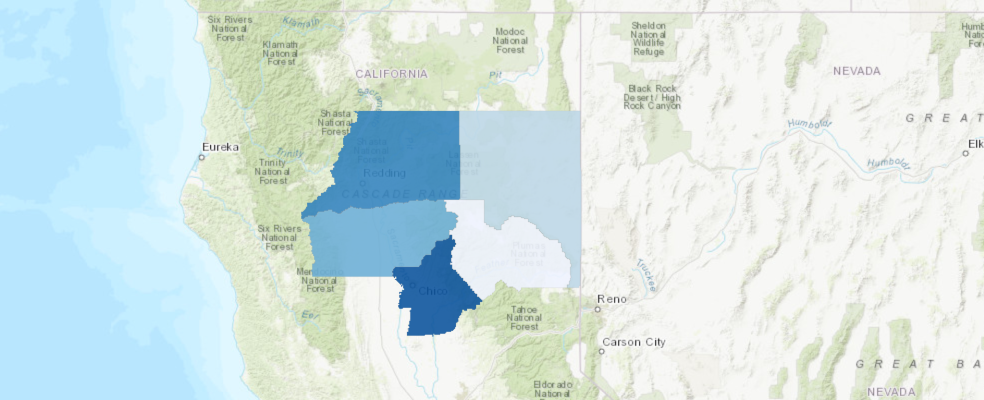

In [125]:
extents = {  'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
             'xmin': -13599903.12077552,
             'ymin': 4835411.413572267,
             'xmax': -13299046.977445211,
             'ymax': 4957710.6588284895}

map0 = gis.map('Plumas National Forest, California')
map0.extent = union_counties.geoextent
map0

In [101]:
lyr = gis.content.import_data(df=counties_df, title="Impacted population sorted by poverty levels, age")

In [123]:
map0.remove_layers()

True


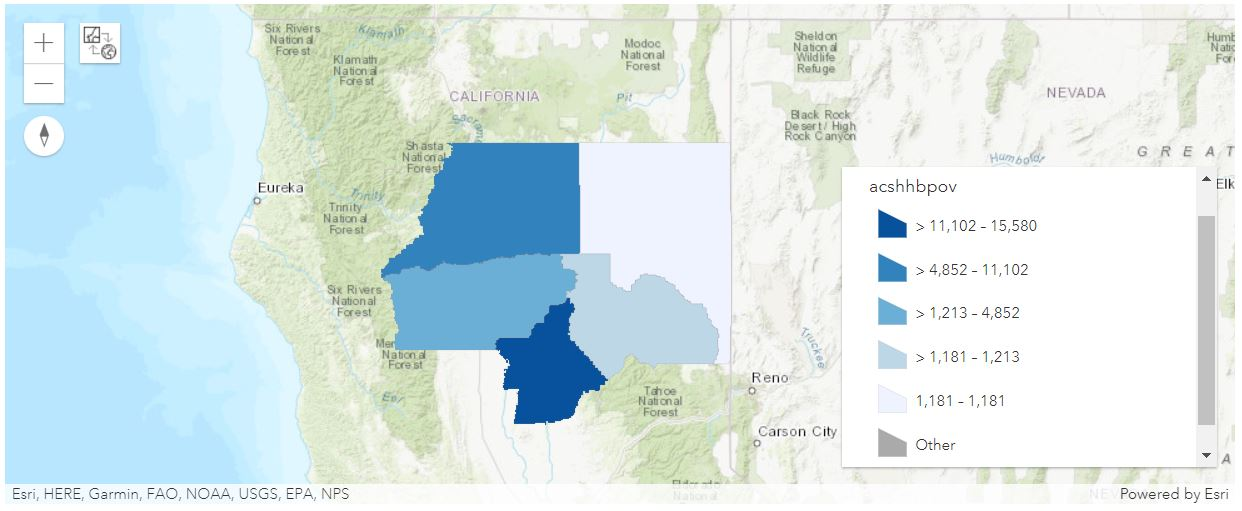

In [127]:
# Populations below poverty lines

In [116]:
# AtRisk.ACSHHBPOV <-> 2019 HHs: Inc Below Poverty Level (ACS 5-Yr)
map0.add_layer(lyr.layers[0], {'renderer': 'ClassedColorRenderer', 
                               'field_name':'ACSHHBPOV'})


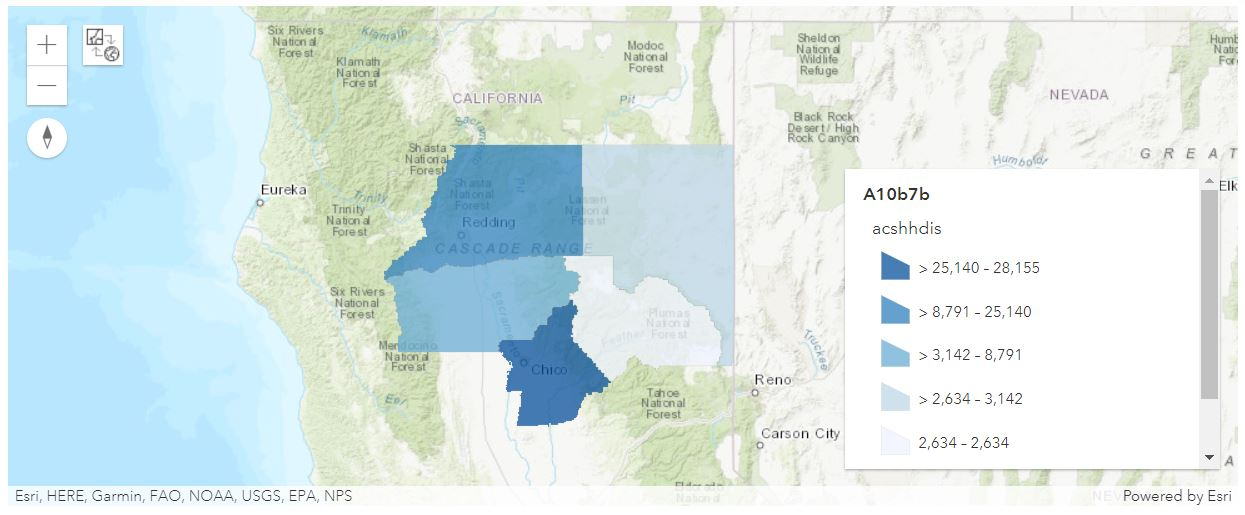

In [126]:
# Population with disabilities

In [120]:
# AtRisk.ACSHHDIS <-> 2019 HHs w/1+ Persons w/Disability (ACS 5-Yr)
map0.add_layer(lyr.layers[0], {'renderer': 'ClassedColorRenderer', 
                               'field_name':'ACSHHDIS',
                               'opacity': 0.75})


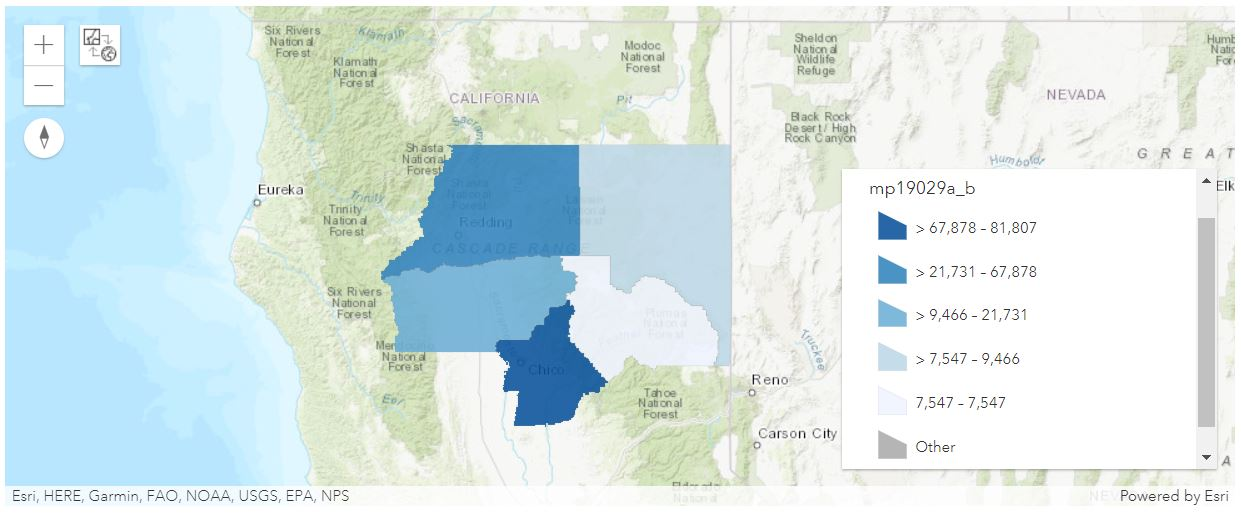

In [128]:
# Populations that use internet for the past month

In [124]:
# AtRisk.MP19029a_B <-> 2021 Used Internet For Latest News/30 Days
map0.add_layer(lyr.layers[0], {'renderer': 'ClassedColorRenderer', 
                               'field_name':'MP19029a_B',
                               'opacity': 0.875})

In [117]:
map0.legend = True

#### Drive Time service areas around fire center

In [156]:
from arcgis.geoenrichment import BufferStudyArea
buffered = BufferStudyArea(area='Storrie Rd, Belden, California, 95915', 
                           radii=[15, 45, 90], units='Minutes', 
                           travel_mode='Driving')
drive_time_df = enrich(study_areas=[buffered], data_collections=['AtRisk'])

In [157]:
drive_time_df

,ID,OBJECTID,sourceCountry,X,Y,areaType,bufferUnits,bufferUnitsAlias,bufferRadii,aggregationMethod,...,MP19029a_B,MP19029a_I,MP21024a_B,MP21024a_I,TADULTBASE,THHBASE,POPU14_CY,SENIORS_CY,PHHU18C10,SHAPE
0,0,1,US,-121.323863,39.917095,NetworkServiceArea,Minutes,Drive Time Minutes,15,BlockApportionment:US.BlockGroups,...,16,103,4,104,32,23,4,11,15.38,"{""rings"": [[[-121.21637976011432, 40.012512507..."
1,0,2,US,-121.323863,39.917095,NetworkServiceArea,Minutes,Drive Time Minutes,45,BlockApportionment:US.BlockGroups,...,3755,84,1268,114,9250,4488,2064,2665,26.20,"{""rings"": [[[-121.10626829164953, 40.133922000..."
2,0,3,US,-121.323863,39.917095,NetworkServiceArea,Minutes,Drive Time Minutes,90,BlockApportionment:US.BlockGroups,...,160245,95,40123,96,347335,165335,83781,79002,32.87,"{""rings"": [[[-121.07417975643845, 40.455878075..."



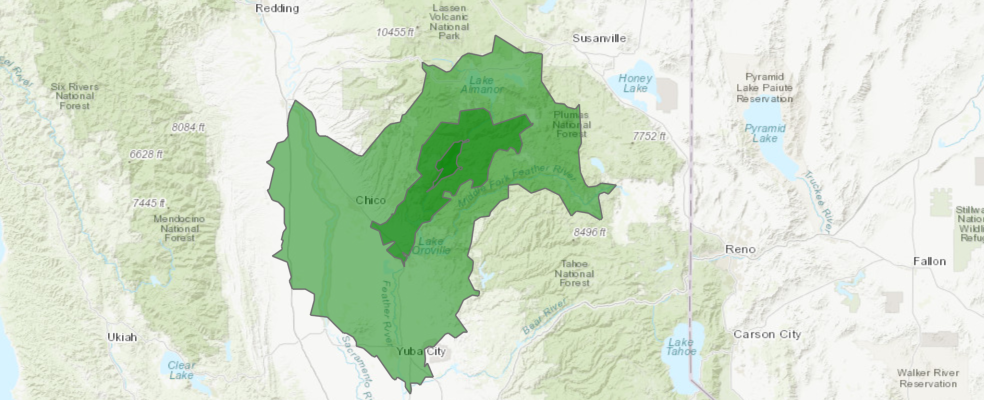

In [162]:
dixie_fire_map = gis.map('Plumas National Forest, CA')

dixie_fire_map

In [159]:
dixie_fire_map.clear_graphics()

In [160]:
drive_time_df.spatial.plot(map_widget=dixie_fire_map)

True

## Conclusion

This notebook demonstrated how to construct spatial filter using `arcgis.goemetry.filters` sub-module. These filters are can be applied when querying feature and imagery layers.

The choice to make between various spatial relations for spatial queries depends on what is known prior to executing the query and the type of results needed. If the goal of the query is to find features that satisfy a spatial relationship with a single geometry (or a collection of geometries), use a spatial filter. 
 
What's not mentioned here but still important for improving efficiencies and precisons of queries, is that users should consider `spatial caching` and `tolerance` when executing spatial queries. If multiple spatial queries are going to be executed within a common extent, the use of spatial caching can significantly increase performance by reducing round trips to the data source. A feature class x,y tolerance can have an effect on the results of a spatial query and should be considered when executing spatial queries, particularly with feature classes that have unusually large x,y tolerances. For more information, please check out <a href="http://resources.esri.com/help/9.3/arcgisengine/dotnet/7b4b8987-a3f0-4954-980f-720e61965449.htm">Resouces on ArcGIS engine</a>.